# PŘÍPRAVA DATASETU

### Načtení potřebných knihoven

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import cv2 as cv
from tqdm.auto import tqdm
import time
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , callbacks
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

import pathlib
import pandas as pd
import matplotlib as mpl

from sklearn.metrics import confusion_matrix , classification_report
import itertools

### Ověření grafických procesorů

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

## Načtení dat do potřebné datové struktury

### Cesty k datasetu

In [2]:
dataset_path = r"C:\Users\HP\Documents\GIT-BP\Screw_ds(50,30,20)_oriented"

train_path = pathlib.Path(dataset_path + '/train')
valid_path = pathlib.Path(dataset_path + '/valid')
test_path  = pathlib.Path(dataset_path + '/test')

### Vytvoření datové struktury

In [3]:
labels='inferred'
    #Either "inferred" (labels are generated from the directory structure),or a list/tuple of integer labels of the same size as the number of image files found in the directory.
    #Labels should be sorted according to the alphanumeric order of the image file paths (obtained via os.walk(directory) in Python).

label_mode='categorical'
    #'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
    #'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
    #'binary' means that the labels (there can be only 2) are encoded as float32 scalars with values 0 or 1 (e.g. for binary_crossentropy).

color_mode='rgb'
    #One of "grayscale", "rgb", "rgba".
    #Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.

image_size=(224, 224)
    #Size to resize images to after they are read from disk.
    #Defaults to (256, 256). Since the pipeline processes batches of images that must all have the same size, this must be provided.

batch_size= 16
    #Size of the batches of data. Default: 32.

shuffle=True
    #Whether to shuffle the data. Default: True. If set to False, sorts the data in alphanumeric order.

seed=3
    #Optional random seed for shuffling and transformations.

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path, 
    labels=labels,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid_path, 
    labels=labels,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path, 
    labels=labels,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=image_size,
    shuffle=shuffle,
    seed=seed)

class_names = test_ds.class_names
print(class_names)

Found 238 files belonging to 6 classes.
Found 141 files belonging to 6 classes.
Found 101 files belonging to 6 classes.
['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


In [4]:
data_augmentation = tf.keras.Sequential([preprocessing.RandomFlip('horizontal')])

#### Předání velikoti obrázků dalším funkcím

In [5]:
a,b = image_size
input_shape = (a,b,3)

### Vizualizace datasetu

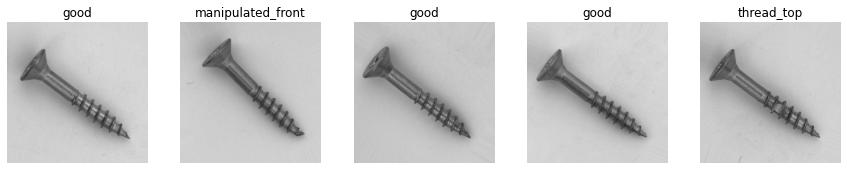

In [6]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")

## Data pipeline

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = (
    train_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
test_ds = (
    test_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
valid_ds = (
    valid_ds
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Konvoluční neuronová síť

### Normalization

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

### Data augmentation

### Předtrénovaná síť

In [9]:
base_model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape= input_shape,
    classifier_activation='softmax'
)

# Freeze the base_model
base_model.trainable = False

### Tvorba modelu

In [10]:
def cnn_model():
    model = tf.keras.Sequential()
    
    #model.add(data_augmentation)
    
    #Pretrained base
    model.add(base_model)
    
    model.add(tf.keras.layers.Flatten())

    #Head
    model.add(tf.keras.layers.Dense(64,
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(16,
                                    activation='relu'))    
    model.add(tf.keras.layers.Dense(6,
                                    activation='softmax'))

    return model

In [11]:
model1 =  cnn_model()

### Konfigurace modelu pro trénování

+ Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

    + https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

In [12]:
optimizer =tf.keras.optimizers.Adam(learning_rate=1e-4)

In [13]:
model1.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

### Early stopping

In [18]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=50,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

## Trénování modelu

In [19]:
history = model1.fit(
    train_ds,
    validation_data = valid_ds,
    epochs=1000,
    verbose = 1,
    callbacks=early_stopping
    )

Epoch 1/600
8/8 [==============================] - 25s 2s/step - loss: 1.1380 - accuracy: 0.7563 - val_loss: 0.9753 - val_accuracy: 0.7660
Epoch 2/600
8/8 [==============================] - 4s 468ms/step - loss: 0.9818 - accuracy: 0.7563 - val_loss: 0.9165 - val_accuracy: 0.7660
Epoch 3/600
8/8 [==============================] - 4s 469ms/step - loss: 0.9265 - accuracy: 0.7563 - val_loss: 0.9016 - val_accuracy: 0.7660
Epoch 4/600
8/8 [==============================] - 4s 470ms/step - loss: 0.9053 - accuracy: 0.7563 - val_loss: 0.8832 - val_accuracy: 0.7660
Epoch 5/600
8/8 [==============================] - 4s 471ms/step - loss: 0.8843 - accuracy: 0.7563 - val_loss: 0.8736 - val_accuracy: 0.7660
Epoch 6/600
8/8 [==============================] - 4s 472ms/step - loss: 0.8665 - accuracy: 0.7563 - val_loss: 0.8618 - val_accuracy: 0.7660
Epoch 7/600
8/8 [==============================] - 4s 473ms/step - loss: 0.8469 - accuracy: 0.7563 - val_loss: 0.8542 - val_accuracy: 0.7660
Epoch 8/600
8/8

Epoch 59/600
8/8 [==============================] - 4s 534ms/step - loss: 0.3419 - accuracy: 0.8992 - val_loss: 0.6020 - val_accuracy: 0.8085
Epoch 60/600
8/8 [==============================] - 4s 536ms/step - loss: 0.3343 - accuracy: 0.9076 - val_loss: 0.6005 - val_accuracy: 0.8085
Epoch 61/600
8/8 [==============================] - 4s 536ms/step - loss: 0.3299 - accuracy: 0.9076 - val_loss: 0.5981 - val_accuracy: 0.8156
Epoch 62/600
8/8 [==============================] - 4s 535ms/step - loss: 0.3245 - accuracy: 0.9076 - val_loss: 0.5952 - val_accuracy: 0.8156
Epoch 63/600
8/8 [==============================] - 4s 536ms/step - loss: 0.3195 - accuracy: 0.9076 - val_loss: 0.5926 - val_accuracy: 0.8227
Epoch 64/600
8/8 [==============================] - 4s 530ms/step - loss: 0.3150 - accuracy: 0.9076 - val_loss: 0.5919 - val_accuracy: 0.8156
Epoch 65/600
8/8 [==============================] - 4s 535ms/step - loss: 0.3087 - accuracy: 0.9118 - val_loss: 0.5912 - val_accuracy: 0.8156
Epoch 

8/8 [==============================] - 4s 533ms/step - loss: 0.0525 - accuracy: 1.0000 - val_loss: 0.5134 - val_accuracy: 0.8652
Epoch 174/600
8/8 [==============================] - 4s 534ms/step - loss: 0.0520 - accuracy: 1.0000 - val_loss: 0.5152 - val_accuracy: 0.8652
Epoch 175/600
8/8 [==============================] - 4s 535ms/step - loss: 0.0512 - accuracy: 1.0000 - val_loss: 0.5146 - val_accuracy: 0.8652
Epoch 176/600
8/8 [==============================] - 4s 534ms/step - loss: 0.0506 - accuracy: 1.0000 - val_loss: 0.5170 - val_accuracy: 0.8652
Epoch 177/600
8/8 [==============================] - 4s 533ms/step - loss: 0.0499 - accuracy: 1.0000 - val_loss: 0.5145 - val_accuracy: 0.8652
Epoch 178/600
8/8 [==============================] - 4s 533ms/step - loss: 0.0494 - accuracy: 1.0000 - val_loss: 0.5171 - val_accuracy: 0.8652
Epoch 179/600
8/8 [==============================] - 4s 532ms/step - loss: 0.0487 - accuracy: 1.0000 - val_loss: 0.5148 - val_accuracy: 0.8652
Epoch 180/600

In [14]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
data_augmentation.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [16]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
Total params: 21,631,222
Trainable params: 1,606,838
Non-trainable params: 20,024,384
_________________________________________________________________


## Vlastnosti modelu

### Uložení modelu

In [ ]:
model_to_save = r"C:\Users\HP\Documents\GIT\models\pretrained_base+NN(same_orientation#83,2%)"
model1.save(filepath=model_to_save , save_format='tf')

###  Načtení modelu

## Vizualizace přesnosti a ztráty naučeného modelu

In [ ]:
model_name = r"C:\Users\HP\Documents\GIT\models\\"

load_model = tf.keras.models.load_model(model_name)

In [20]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [21]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(16,10))
    plt.rcParams['font.size'] = '16'
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'b-', label = "Na trénovacích datech")
    plt.plot(history.history['val_accuracy'], 'r-', label = "Na validačních datech")
    plt.ylabel("Správnost",fontsize=18)
    plt.xlabel("Iterace",fontsize=18)
    plt.legend(fontsize=16)

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'b-', label = "Na trénovacích datech")
    plt.plot(history.history['val_loss'], 'r-', label = "Na validačních datech")
    plt.ylabel("Ztráta",fontsize=18)
    plt.xlabel("Iterace",fontsize=18)

    plt.legend(fontsize=16)
    plt.show()
    
history_frame = pd.DataFrame(history.history)

       loss  accuracy  val_loss  val_accuracy
0  1.138045  0.756303  0.975323      0.765957
1  0.981800  0.756303  0.916499      0.765957
2  0.926520  0.756303  0.901632      0.765957
3  0.905326  0.756303  0.883221      0.765957
4  0.884260  0.756303  0.873552      0.765957


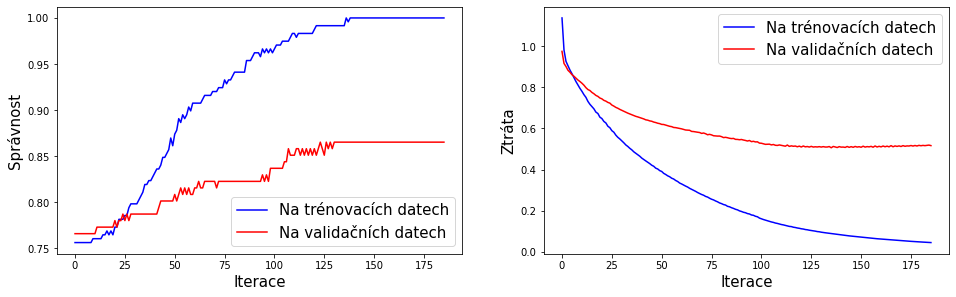

In [22]:
print(history_frame.head())
plot_accuracy_loss(history)

In [23]:
test_loss, test_acc = model1.evaluate(test_ds)
print(str(test_acc*100) + '%')

4/4 [==============================] - 4s 1s/step - loss: 0.4468 - accuracy: 0.8614
86.13861203193665%


## Matice záměn (Confusion matrix)

+ https://stackoverflow.com/questions/64622210/how-to-plot-confusion-matrix-for-prefetched-dataset-in-tensorflow
+ https://deeplizard.com/learn/video/km7pxKy4UHU

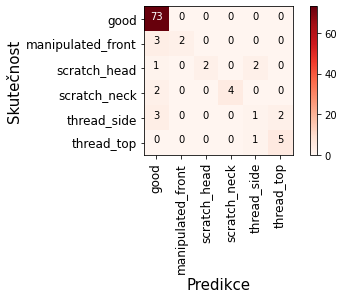

In [30]:
# Predikované rozdělení obrázků do tříd
image_predict = model1.predict(test_ds)
#print(image_predict)
image_predict = np.argmax(image_predict, axis=1)

# Skutečné rozdělení obrázků
image_true = tf.concat([y for x, y in test_ds], axis=0)
image_true = np.argmax(image_true, axis=1)

cm = confusion_matrix(y_true=image_true, y_pred=image_predict)


def plot_confusion_matrix(cm, classes,cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=12)
    plt.yticks(tick_marks, classes,fontsize=12)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Skutečnost',fontsize=15)
    plt.xlabel('Predikce',fontsize=15)
    
    
plot_confusion_matrix(cm=cm, classes=class_names)

In [25]:
print(classification_report(image_true, image_predict, target_names=class_names))

                   precision    recall  f1-score   support

             good       0.89      1.00      0.94        73
manipulated_front       1.00      0.40      0.57         5
     scratch_head       1.00      0.40      0.57         5
     scratch_neck       1.00      0.67      0.80         6
      thread_side       0.25      0.17      0.20         6
       thread_top       0.71      0.83      0.77         6

         accuracy                           0.86       101
        macro avg       0.81      0.58      0.64       101
     weighted avg       0.86      0.86      0.84       101

